# Bert Partition

## Imports

In [4]:
!pip install transformers datasets evaluate wandb umap-learn hdbscan minicons seaborn -q

DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
import datasets

from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    AutoModelForMaskedLM,
    get_scheduler
)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from tqdm.auto import trange, tqdm
import pandas as pd
import minicons

import umap
from matplotlib import pyplot as plt
import hdbscan
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances

In [6]:
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from MinioHandler import MinioHandler

In [14]:
minio = MinioHandler()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Parameters

In [ ]:
# wandb.login()

In [ ]:
# wandb.init(
#     project='grammar-bert-model1',
#     entity='grammar-bert'
# )

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [8]:
SEQ_LEN = 64
BATCH_SIZE = 32

DATA_PATH = '../data/test_dataset.csv'
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
WEIGHTS_PATH = "ckpt/pretrained_bert/model_epoch_9.pt"

## Data Preparation

In [9]:
df = pd.read_csv(DATA_PATH)
data = datasets.Dataset.from_pandas(df)
# data = data.train_test_split(test_size=TEST_SIZE)

del df

In [23]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
class PairsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.dataset = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text1 = self.tokenizer(self.dataset[idx]['initial'],
                     padding='max_length',
                     truncation=True,
                     max_length=SEQ_LEN,
                     return_tensors='pt')

        text2 = self.tokenizer(self.dataset[idx]['polypers'],
                     padding='max_length',
                     truncation=True,
                     max_length=SEQ_LEN,
                     return_tensors='pt')

        return text1, text2

In [ ]:
# tokenizer.pad_token = '[SEP]'
# tokenizer.eos_token = '[SEP]'
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=MLM_PROB)

## Model

In [ ]:
def vectorize(model, data, metric, division_layer=3):
    model.eval()

    res = []

    with torch.no_grad():
        for batch in tqdm(data):
            ref = model(**{k: v.to(model.device).squeeze() for k, v in batch[0].items()},
                         output_hidden_states=True)
            cur = model(**{k: v.to(model.device).squeeze() for k, v in batch[1].items()},
                         output_hidden_states=True)

            ref = torch.mean(ref.hidden_states[division_layer], dim=1)
            cur = torch.mean(cur.hidden_states[division_layer], dim=1)

            dist = metric(ref, cur)

            res.append(dist)

    return torch.vstack(res)

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.to(device)
pass

In [ ]:
dt = PairsDataset(data.select(range(10000)), tokenizer)
dl = DataLoader(dt,
                batch_size=BATCH_SIZE,
                shuffle=False)

### MLM scoring

In [10]:
mlm_model = minicons.scorer.MaskedLMScorer(MODEL_NAME, 'cpu')

In [12]:
mlm_model.model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [15]:
ckpt = minio.get_object(WEIGHTS_PATH, type="model")
model_dict = torch.load(ckpt)
mlm_model.model.load_state_dict(model_dict["model_state_dict"])

<All keys matched successfully>

In [18]:
stimuli = ['Маша переигрывает команду галактических велоцирапторов на их же бурлящем магмой поле.']

In [19]:
# un-normalized sequence score
print(mlm_model.sequence_score(stimuli, reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r'))

[134.26399612426758]


In [20]:
# original metric, for comparison:
print(mlm_model.sequence_score(stimuli, reduction = lambda x: -x.sum(0).item(), PLL_metric='original'))

[93.11190700531006]


In [21]:
# per token mlm score
print(mlm_model.token_score(stimuli, PLL_metric='within_word_l2r'))1

[[('Маша', -12.587450981140137), ('переиг', -14.254874229431152), ('##рывает', -0.4623374938964844), ('команду', -9.60151481628418), ('галакт', -8.8409423828125), ('##ических', -0.014862060546875), ('вело', -13.663464546203613), ('##цир', -6.844906806945801), ('##апт', -8.591144561767578), ('##оров', -6.174256324768066), ('на', -1.4734535217285156), ('их', -6.746120452880859), ('же', -5.701460838317871), ('бур', -10.220565795898438), ('##лящ', -0.07884597778320312), ('##ем', -0.1305370330810547), ('маг', -10.470340728759766), ('##мой', -16.099409103393555), ('поле', -2.2501354217529297), ('.', -0.057373046875)]]


In [22]:
# original values, for comparison (notice the 'souvenir' tokens):
print(mlm_model.token_score(stimuli, PLL_metric='original'))

[[('Маша', -12.587450981140137), ('переиг', -4.0276384353637695), ('##рывает', -0.4623374938964844), ('команду', -9.60151481628418), ('галакт', -3.6987552642822266), ('##ических', -0.014862060546875), ('вело', -5.3268022537231445), ('##цир', -5.495798110961914), ('##апт', -11.20201301574707), ('##оров', -6.174256324768066), ('на', -1.4734535217285156), ('их', -6.746120452880859), ('же', -5.701460838317871), ('бур', -0.0032787322998046875), ('##лящ', -0.00061798095703125), ('##ем', -0.1305370330810547), ('маг', -2.0580921173095703), ('##мой', -16.099409103393555), ('поле', -2.2501354217529297), ('.', -0.057373046875)]]


Test dataset scoring

In [31]:
list(
    zip(
    data["base"][:20], 
         mlm_model.sequence_score(data["base"][:20], reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r')
    )
)

[('Штурман доложил, что расстояние от «Каймана» до «Колумба» в семь раз короче расстояния от шхуны до эсминца.',
  22.310338973999023),
 ('Я смотрел на топчанчик и не сразу заметил доктора Грейсона, который надевал халат.',
  29.583410263061523),
 ('Пришлось зачеркнуть и "во-первых" и "во-вторых" и написать просто: "потому что каникулы".',
  39.367451190948486),
 ('Будем растить мастеров своего дела.', 28.53250789642334),
 ('Вам, думается, тоже, а мне-то ведь есть что терять.', 32.07039785385132),
 ('А каково командиру?', 16.114497184753418),
 ('Глубина здесь была не столь велика, но течение необыкновенно сильное, вода ледяная и скользкое, покатое дно.',
  46.90057373046875),
 ('Не правда ли, вы заставите, штурмбаннфюрер?', 27.846832275390625),
 ('Записали о нем в вахтенный журнал.', 12.574165344238281),
 ('А вы — в Трое.', 18.204448699951172),
 ('Очнувшись, я увидел, что Гюнтер яростно тащит свой аппарат к завалу.',
  37.308902740478516),
 ('«Колумб» могли узнать и подойти к нему хотя

In [30]:
list(
    zip(
    data["polypers"][:20], 
         mlm_model.sequence_score(data["polypers"][:20], reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r')
    )
)

[('Штурман доложил , что расстояние от « Каймана » до « Колумба » в семь раз короче расстояния от шхуны до эсминца .',
  22.310338973999023),
 ('Я смотрел на топчанчик и не сразу заметилет доктора Грейсона , который надевалет халат .',
  72.28310823440552),
 ('Пришлось зачеркнуть и " во-первых " и " во-вторых " и написать просто : " потому что каникулы " .',
  39.367451190948486),
 ('Будем растить мастеров своего дела .', 28.53250789642334),
 ('Вам , думается , тоже , а мне-то ведь есть что терять .',
  32.07039785385132),
 ('А каково командиру ?', 16.114497184753418),
 ('Глубина здесь была не столь велика , но течение необыкновенно сильное , вода ледяная и скользкое , покатое дно .',
  46.90057373046875),
 ('Не правда ли , вы заставите , штурмбаннфюрер ?', 27.846832275390625),
 ('Записали о нем в вахтенный журнал .', 12.574165344238281),
 ('А вы — в Трое .', 18.204448699951172),
 ('Очнувшись , я увидел , что Гюнтер яростно тащитет свой аппарат к завалу .',
  65.07012510299683),
 ('« К

Метрики:
- Норма вектора разницы
- Евклид
-

In [ ]:
metric = lambda x, y: abs(x - y)

In [ ]:
vecs = vectorize(model, dl, metric, division_layer=4)
vecs.shape

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([10000, 768])

<Axes: ylabel='Count'>

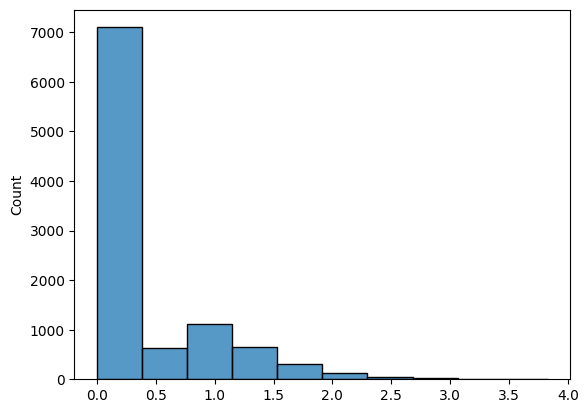

In [ ]:
sns.histplot(torch.linalg.vector_norm(vecs, ord=2, dim=1).cpu(), bins=10)

In [ ]:
torch.where(vecs.sum(dim=1) != 0)[0].shape

torch.Size([2897])

In [ ]:
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.2,
                    n_components=2,
                    metric='euclidean',
                    random_state=40)

In [ ]:
embedding = reducer.fit_transform(vecs.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


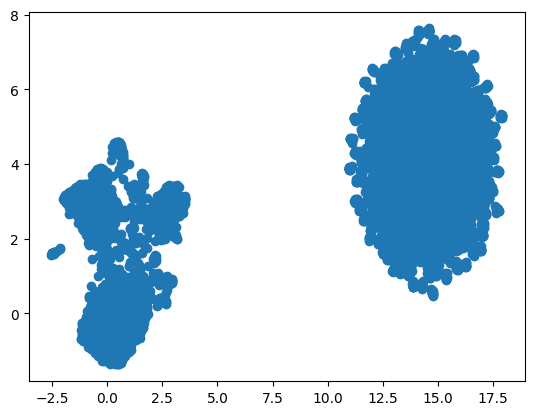

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1])

In [ ]:
vecs_diff = vecs[torch.where(vecs.sum(dim=1) != 0)[0]].cpu()
mn_vec = vecs_diff.mean(dim=0).cpu()

In [ ]:
cos = torch.nn.functional.cosine_similarity(vecs_diff, mn_vec.view(1, -1), dim=1)
norm = torch.linalg.vector_norm(vecs_diff, ord=2, dim=1).cpu()

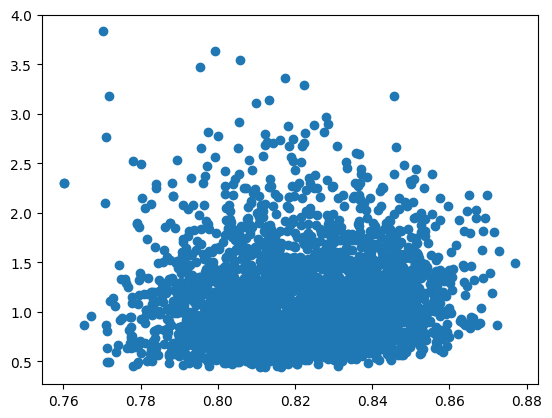

In [ ]:
plt.scatter(cos, norm)

In [ ]:
clusterer = hdbscan.HDBSCAN()

In [ ]:
clusterer.fit(blobs)